- Copyright 2020 Norwegian Meteorological Institute
- Author Jean Rabault
- this file is released with the same copyright as found in the LICENSE file

The "dataset_observation_*.nc4" files used here contain data obtained form kartverket API:

https://www.kartverket.no/en/sehavniva/api-for-water-level-data-and-widget/

https://www.kartverket.no/data/lisens/

These data are relased under CC BY 4.0 license, a copy of their license is accessible at: https://creativecommons.org/licenses/by/4.0/deed.en we gratefully acknowledge the release of these data

The data collection through kartverket API was performed using code at: https://github.com/jerabaul29/kartverket_storm_surge_data


In this notebook, we illustrate how pytide can be used to learn tide modes from data and perform predictions.

In [1]:
import pytide
import os
import time as time_module
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import netCDF4
import datetime
import pytz
import numpy as np

from helpers import datetime_range

# Make sure the interpreter is in UTC in all the following
os.environ["TZ"] = "UTC"
time_module.tzset()

# An example with simulation data

prefer using datetime.timezone.utc to pytz.utc
prefer using datetime.timezone.utc to pytz.utc


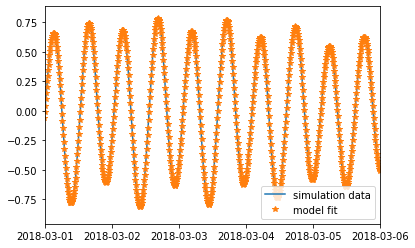

In [2]:
# load the dataset
path_to_data = os.path.join(os.path.dirname(os.getcwd()),
                            "tests", "dataset",
                            "fes_tide_time_series.nc")

with netCDF4.Dataset(path_to_data) as dataset:
    time = dataset['time'][:] * 1e-6    # microseconds to epoch (seconds)
    h = dataset['ocean'][:]

time_as_datetimes = [datetime.datetime.fromtimestamp(crrt_timestamp) for
                        crrt_timestamp in time]

# build pytide wave table with all modes
wt = pytide.WaveTable()

# compute the nodal modulations corresponding to the times
f, vu = wt.compute_nodal_modulations(time_as_datetimes)

# build modes table from the available records
w = wt.harmonic_analysis(h, f, vu)

datetime_prediction = \
    list(datetime_range(pytz.utc.localize(time_as_datetimes[0]),
                        pytz.utc.localize(time_as_datetimes[-1]),
                        datetime.timedelta(minutes=10)))

time_prediction = [crrt_datetime.timestamp() for
                    crrt_datetime in datetime_prediction]

hp = wt.tide_from_tide_series(time_prediction, w)

# show the results
plt.figure()

plt.plot(time_as_datetimes, h, label="simulation data")
plt.plot(datetime_prediction, hp, "*", label="model fit")

plt.legend(loc="lower right")

# put some restrictive limites otherwise nothing is visible with inline figures
if True:
    plt.xlim([mdates.date2num(datetime.datetime(2018, 3, 1, 0, 0)),
             mdates.date2num(datetime.datetime(2018, 3, 6, 0, 0))])

plt.show()

# An example with real-world data from kartverket

In [3]:
def RMSE_stats(observations,
               official_predictions, pytide_predictions,
               explanation=""):
    """Print some RMSE statistics about the comparison between observations,
    official predictions, and pytide predictions.
    Input:
        - observations: real-world observations, np float array
        - *_predictions: the predictions, np float arrays
        - explanation: str to display when printing information.
    """
    RMSE_pytide = \
        np.sqrt(np.mean((observations - pytide_predictions)**2))
    RMSE_predictions = \
        np.sqrt(np.mean((observations - official_predictions)**2))
    RMSE_pytide_predictions = \
        np.sqrt(np.mean((pytide_predictions - official_predictions)**2))

    print("RMSE pytide vs obs {}: {}".format(explanation, RMSE_pytide))
    print("RMSE official prediction vs obs {}: {}".format(explanation, RMSE_predictions))
    print("RMSE pytide vs official predictions {}: {}".format(explanation, RMSE_pytide_predictions))


def show_tides(time_as_datetimes, observations,
               pytide_predictions, official_predictions,
               print_stats=True, explanation="", xlims=None):
    """Show the tide observation vs predictions by pytides and official predictions.
    Input:
        - time_as_datetimes: list of datetimes as time base
        - observations: np array of real-world observations
        - *_predictions: np array of predictions.
        - print_stats: whether to print RMSE stats
        - explanation: the explanation to display about the RMSE context
        - xlims: limits for the plot
    """
    if print_stats:
        RMSE_stats(observations, official_predictions, pytide_predictions, explanation)

    plt.figure()

    plt.plot(time_as_datetimes, observations, label="observations")
    plt.plot(time_as_datetimes, pytide_predictions, "*", label="pytide prediction")
    plt.plot(time_as_datetimes, official_predictions, "+", label="dataset predictions")
    plt.ylabel("[cm]")

    plt.legend(loc="lower right")
    
    plt.title(explanation)
    
    if xlims is not None:
        plt.xlim(xlims)

    plt.show()

RMSE pytide vs obs on half middle dataset, i.e. used for training: 13.556280886895994
RMSE official prediction vs obs on half middle dataset, i.e. used for training: 14.016977310180664
RMSE pytide vs official predictions on half middle dataset, i.e. used for training: 3.631455890767457
RMSE pytide vs obs on full middle dataset: 13.241728458392714
RMSE official prediction vs obs on full middle dataset: 13.413595199584961
RMSE pytide vs official predictions on full middle dataset: 3.7034356020030317


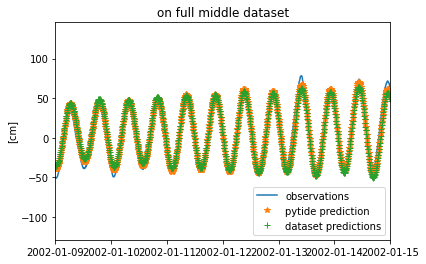

RMSE pytide vs obs on data much before the training interval: 13.337207098084466
RMSE official prediction vs obs on data much before the training interval: 13.388086318969727
RMSE pytide vs official predictions on data much before the training interval: 3.74480064786738


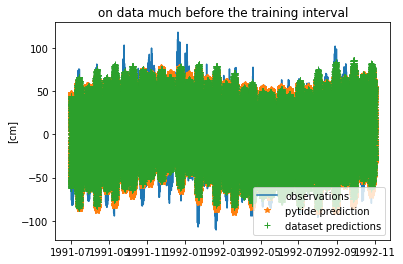

RMSE pytide vs obs on data much after the training interval: 12.943336740225218
RMSE official prediction vs obs on data much after the training interval: 13.052495956420898
RMSE pytide vs official predictions on data much after the training interval: 3.5885249161493893


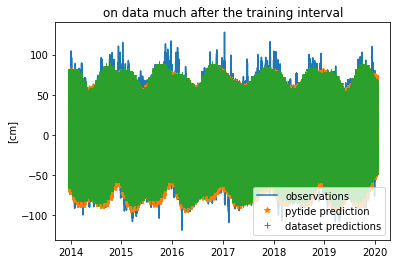

In [4]:
# load the dataset for the "middle"
path_to_data = os.path.join(os.path.dirname(os.getcwd()),
                            "tests", "dataset",
                            "dataset_observation_middle.nc4")

with netCDF4.Dataset(path_to_data) as dataset:
    time = dataset['timestamps'][:]
    observations = dataset['observations'][:]
    official_predictions = dataset['predictions'][:]

mean_observations = np.mean(observations)
observations = observations - mean_observations
official_predictions = official_predictions - mean_observations

time_as_datetimes = [datetime.datetime.fromtimestamp(crrt_timestamp) for
                        crrt_timestamp in time]

index_half_data = len(time) // 2

# build pytide wave table with all modes
wt = pytide.WaveTable()

##############################
# We perform the training on only half the middle dataset, to allow for "validation error vs prediction error"

# compute the nodal modulations corresponding to the times
# based on half of the data
f, vu = wt.compute_nodal_modulations(time_as_datetimes[:index_half_data])

# build modes table from the available records
# based on half of the data
w = wt.harmonic_analysis(observations[:index_half_data],
                            f[:index_half_data],
                            vu[:index_half_data])

# predict over a time range, for the full dataset
pytide_predictions = wt.tide_from_tide_series(time, w)

# print some statistics

# on half of the data
RMSE_stats(observations[:index_half_data],
            official_predictions[:index_half_data], pytide_predictions[:index_half_data],
            explanation="on half middle dataset, i.e. used for training")

##############################
# show the results
show_tides(time_as_datetimes, observations, pytide_predictions, official_predictions,
            print_stats=True, explanation="on full middle dataset",
          xlims=[mdates.date2num(datetime.datetime(2002, 1, 9, 0, 0)),
                mdates.date2num(datetime.datetime(2002, 1, 15, 0, 0))])

##############################
# now show the predictions on some data long before and after the interval used for fitting

path_to_early_data = os.path.join(os.path.dirname(os.getcwd()),
                                    "tests", "dataset",
                                    "dataset_observation_before.nc4")

with netCDF4.Dataset(path_to_early_data) as dataset:
    early_time = dataset['timestamps'][:]
    early_observations = dataset['observations'][:]
    early_official_predictions = dataset['predictions'][:]

early_observations = early_observations - mean_observations
early_official_predictions = early_official_predictions - mean_observations
early_time_as_datetimes = [datetime.datetime.fromtimestamp(crrt_timestamp) for
                            crrt_timestamp in early_time]

early_pytide_predictions = wt.tide_from_tide_series(early_time, w)

show_tides(early_time_as_datetimes, early_observations, early_pytide_predictions, early_official_predictions,
           explanation="on data much before the training interval"
          )

##############################
# now show on some data long after
path_to_late_data = os.path.join(os.path.dirname(os.getcwd()),
                                    "tests", "dataset",
                                    "dataset_observation_after.nc4")

with netCDF4.Dataset(path_to_late_data) as dataset:
    late_time = dataset['timestamps'][:]
    late_observations = dataset['observations'][:]
    late_official_predictions = dataset['predictions'][:]

late_observations = late_observations - mean_observations
late_official_predictions = late_official_predictions - mean_observations
late_time_as_datetimes = [datetime.datetime.fromtimestamp(crrt_timestamp) for
                            crrt_timestamp in late_time]

late_pytide_predictions = wt.tide_from_tide_series(late_time, w)

show_tides(late_time_as_datetimes, late_observations, late_pytide_predictions, late_official_predictions,
            explanation="on data much after the training interval")